In [7]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации.
# 4. Вывести результат

### 1.Импорт библиотек

In [8]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


### 2.Вспомогательные функции и классы (центрирование, загрузка, генерация, сегментация)

In [9]:
def center_in_45(image, target_size=45):
    h, w = image.shape

    squared = np.zeros((target_size, target_size), dtype=np.uint8)

    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2

    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []

    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)

        images = [f for f in os.listdir(symbol_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()

        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        mapped_symbol = symbol

        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(mapped_symbol)

    return np.array(X_train), np.array(y_train)

def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

class SequenceGenerator:
    def __init__(self, data_path):
        self.data_path = data_path

        self.available_symbols = []
        self.load_symbols()

    def load_symbols(self):
        """Загрузка всех символов из папок"""
        folders = [f for f in os.listdir(self.data_path)
                  if os.path.isdir(os.path.join(self.data_path, f))]

        print("Загружаемые символы:", folders)

        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []

            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)

            if images:
                self.available_symbols.append({
                    'symbol': folder,
                    'images': images
                })

        print(f"Загружено {len(self.available_symbols)} типов символов")

    def generate_sequence_image(self, length=6):
        """Генерация изображения с последовательностью символов"""
        if not self.available_symbols:
            return None

        sequence = []
        labels = []

        for _ in range(length):
            symbol_data = random.choice(self.available_symbols)
            symbol = symbol_data['symbol']
            img = random.choice(symbol_data['images']).copy()

            img = center_in_45(img)

            sequence.append(img)
            labels.append(symbol)

        height = 45
        width = 45 * length
        combined = np.zeros((height, width), dtype=np.uint8)

        for i, img in enumerate(sequence):
            combined[:, i*45:(i+1)*45] = img

        return {
            'image': combined,
            'labels': labels,
            'text': ''.join(labels)
        }

class SequenceSegmenter:
    def __init__(self):
        pass

    def extract_characters(self, sequence_img, true_labels=None):
        """Извлечение отдельных символов из изображения последовательности"""
        characters = []

        if true_labels:
            for i, label in enumerate(true_labels):
                x_start = i * 45
                char_img = sequence_img[:, x_start:x_start+45]
                characters.append({
                    'image': char_img,
                    'true_label': label,
                    'position': i
                })
        else:
            num_chars = sequence_img.shape[1] // 45
            for i in range(num_chars):
                x_start = i * 45
                char_img = sequence_img[:, x_start:x_start+45]
                characters.append({
                    'image': char_img,
                    'position': i
                })

        return characters


### 3.Загрузка данных и обучение моделей KNN

In [10]:
DATA_PATH = './data'

print("=" * 60)
print("ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 60)

symbols = []
if os.path.exists(DATA_PATH):
    symbols = [f for f in os.listdir(DATA_PATH)
               if os.path.isdir(os.path.join(DATA_PATH, f))]

print("Доступные символы:", symbols)

if not symbols:
    print("Нет символов для обучения!")
    raise ValueError("Отсутствуют данные для обучения")

X_train, y_train = load_training_data(DATA_PATH, symbols)

print(f"Загружено {len(X_train)} обучающих примеров")

models = {}

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
models['knn1'] = knn1
print("KNN-1 обучен")

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
models['knn3'] = knn3
print("KNN-3 обучен")

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
models['knn5'] = knn5
print("KNN-5 обучен")

knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, y_train)
models['knn7'] = knn7
print("KNN-7 обучен")

print("Все модели успешно обучены!")


ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ
Доступные символы: ['times', '9', '0', '7', '+', ',', '6', '1', '8', 't', '-', 'h', '(', '4', 'X', '3', ')', '2', 'y', '5', 'w']
Загружено 180225 обучающих примеров
KNN-1 обучен
KNN-3 обучен
KNN-5 обучен
KNN-7 обучен
Все модели успешно обучены!


### 4.Тестирование на сгенерированной последовательности


ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ
Загружаемые символы: ['times', '9', '0', '7', '+', ',', '6', '1', '8', 't', '-', 'h', '(', '4', 'X', '3', ')', '2', 'y', '5', 'w']
Загружено 21 типов символов
1) text:   text
   labels: labels
2) text:   text
   labels: labels
3) text:   text
   labels: labels


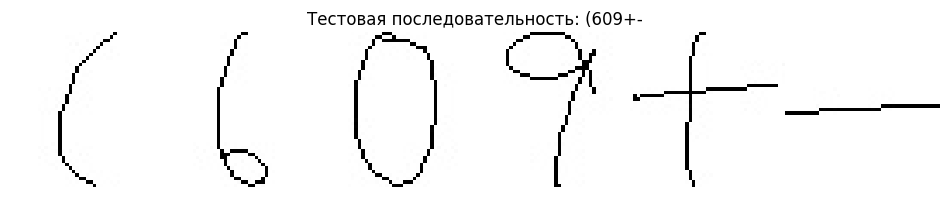


Тестирование knn1:
  Позиция 1: ( -> (
  Позиция 2: 6 -> 6
  Позиция 3: 0 -> 0
  Позиция 4: 9 -> 9
  Позиция 5: + -> +
  Позиция 6: - -> -
    Оригинал:  (609+-
    Предсказано: (609+-
    Точность: 100.0% (6/6)

Тестирование knn3:
  Позиция 1: ( -> (
  Позиция 2: 6 -> (
  Позиция 3: 0 -> 0
  Позиция 4: 9 -> 4
  Позиция 5: + -> +
  Позиция 6: - -> -
    Оригинал:  (609+-
    Предсказано: ((04+-
    Точность: 66.7% (4/6)

Тестирование knn5:
  Позиция 1: ( -> (
  Позиция 2: 6 -> (
  Позиция 3: 0 -> 0
  Позиция 4: 9 -> 4
  Позиция 5: + -> +
  Позиция 6: - -> -
    Оригинал:  (609+-
    Предсказано: ((04+-
    Точность: 66.7% (4/6)

Тестирование knn7:
  Позиция 1: ( -> (
  Позиция 2: 6 -> (
  Позиция 3: 0 -> 0
  Позиция 4: 9 -> 4
  Позиция 5: + -> +
  Позиция 6: - -> -
    Оригинал:  (609+-
    Предсказано: ((04+-
    Точность: 66.7% (4/6)


In [13]:
print("\n" + "=" * 60)
print("ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
print("=" * 60)

generator = SequenceGenerator(DATA_PATH)
sequence_data = generator.generate_sequence_image(length=6)

N = 3
L = 6

for i in range(N):
    seq_img, labels, text = generator.generate_sequence_image(length=L)
    print(f"{i+1}) text:   {text}")
    print(f"   labels: {labels}")


if sequence_data:
    plt.figure(figsize=(12, 3))
    plt.imshow(sequence_data['image'], cmap='gray')
    plt.title(f'Тестовая последовательность: {sequence_data["text"]}')
    plt.axis('off')
    plt.show()

    segmenter = SequenceSegmenter()
    characters = segmenter.extract_characters(sequence_data['image'], sequence_data['labels'])

    results = {}

    for model_name, model in models.items():
        print(f"\nТестирование {model_name}:")

        predicted_labels = []
        for char_data in characters:
            pred = predict_symbol(model, char_data['image'])
            predicted_labels.append(pred)

            print(f"  Позиция {char_data['position']+1}: {char_data['true_label']} -> {pred}")

        original_text = ''.join(sequence_data['labels'])
        predicted_text = ''.join(predicted_labels)

        correct = sum(1 for true, pred in zip(sequence_data['labels'], predicted_labels) if true == pred)
        total = len(sequence_data['labels'])
        accuracy = correct / total

        print(f"    Оригинал:  {original_text}")
        print(f"    Предсказано: {predicted_text}")
        print(f"    Точность: {accuracy:.1%} ({correct}/{total})")

        results[model_name] = {
            'accuracy': accuracy,
            'predicted': predicted_text,
            'correct': correct,
            'total': total
        }


### 5.Финальные результаты

In [15]:
print("\n" + "=" * 60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("=" * 60)

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    print(f"{model_name}: {result['accuracy']:.1%} - '{result['predicted']}'")

best_accuracy = sorted_results[0][1]['accuracy']
best_models = [model for model, res in results.items() if res['accuracy'] == best_accuracy]

if len(best_models) == 1:
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_models[0]} с точностью {best_accuracy:.1%}")
else:
    print(f"НЕСКОЛЬКО ЛУЧШИХ МОДЕЛЕЙ с точностью {best_accuracy:.1%}: {', '.join(best_models)}")



ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ
knn1: 100.0% - '(609+-'
knn3: 66.7% - '((04+-'
knn5: 66.7% - '((04+-'
knn7: 66.7% - '((04+-'
ЛУЧШАЯ МОДЕЛЬ: knn1 с точностью 100.0%
